# Data Augmentation

- Artificiellt skapar mer bilder, när vi har lite data
- Slumpmässigt roterar till en viss grad (radianer)
- Slumpämssigt translatera
- Slumpmässigt flippa horisontellt, vertikalt (spegla)
- shear / skjuvning
- ...

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.datasets.mnist import load_data



In [2]:
(X_train, y_train), (X_test, y_test) = load_data()

In [21]:
def plot_samples(data, nrows=2, ncols=5, figsize=(12, 4)):
    
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i,:,:], cmap="gray") #0-9 and all rows and columns
        ax.axis("off")

    fig.subplots_adjust(wspace=0, hspace=.1, bottom=0)

In [3]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_test.min(), X_test.max()

(0.0, 1.0)

### Train | val | test split

In [13]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1/6, random_state = 42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape, X_val.shape, y_train_val.shape, y_val.shape

((50000, 28, 28, 1), (10000, 28, 28, 1), (50000,), (10000,))

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
                        rotation_range=10,
                        shear_range=.2,
                        zoom_range=.1,
                        horizontal_flip=False, 
                        height_shift_range=.2, 
                        width_shift_range=.2
                        )

# Don't augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x149b981f0>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x149c9b550>)

2
(32, 28, 28, 1)


array([8, 6, 3, 2, 5, 7, 6, 3, 3, 7, 6, 4, 1, 4, 4, 1, 1, 5, 8, 9, 3, 4,
       5, 6, 7, 3, 8, 9, 4, 7, 4, 9], dtype=uint8)

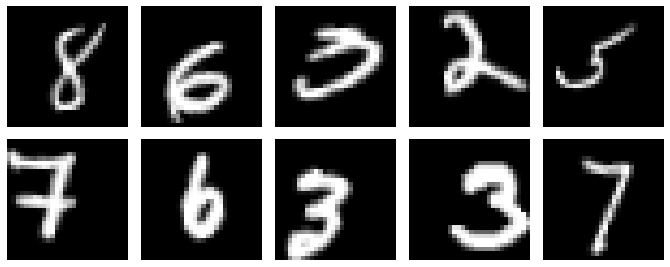

In [27]:
print(len(train_val_generator.next())) #next is an iterator object, .next brings us to the next batch

sample_batch = train_val_generator.next() #32 samples with 28*28 pixels in our first batch
print(sample_batch[0].shape)

plot_samples(sample_batch[0])
sample_batch[1]

### CNN Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=.001, drop_rate=.5, kernels=[32, 32]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name="CNN_model")

    # The convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, 
                            kernel_size=(3, 3), 
                            activation="relu", 
                            kernel_initializer="he_normal", 
                            input_shape=X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"])

    return model

model = CNN_model(drop_rate=.5)
model.summary()    

2022-04-28 10:05:41.631239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0 